**Description**: Investigate ROC curves and similar to find good cutoff points.

In [1]:
import numpy as np
from gnn_tracking_hpo.util.paths import find_checkpoints, add_scripts_path

add_scripts_path()

In [2]:
from gnn_tracking_hpo.util.paths import get_config

checkpoint_path = find_checkpoints("ec-s9", "009d")[-1]
config = get_config("ec-s9", "009d")

In [3]:
config.update({"n_graphs_train": 1, "n_graphs_val": 100, "n_graphs_test": 1})

In [4]:
from tune_ec_sectorized import ECTrainable

In [5]:
trainable = ECTrainable(config)

DEBUG: Got config
{'batch_size': 1,
 'focal_alpha': 0.7397820322968228,
 'focal_gamma': 4,
 'gnn_tracking_experiments_hash': '1c4385064cb8472d7070c92d38d2958ab96e7485',
 'gnn_tracking_hash': 'd1903e7319ef1dc27f2632d27212ce802d1273e2',
 'lr': 0.00010008424753725798,
 'lw_edge': 1.0,
 'm_L_ec': 7,
 'm_alpha_ec': 0.5082980468439962,
 'm_e_dim': 4,
 'm_h_dim': 5,
 'm_hidden_dim': 118,
 'm_interaction_edge_hidden_dim': 85,
 'm_interaction_node_hidden_dim': 94,
 'n_graphs_test': 1,
 'n_graphs_train': 1,
 'n_graphs_val': 100,
 'optimizer': 'adam',
 'scheduler': None,
 'sector': 9,
 'test': False,
 'training_pt_thld': 0.0,
 'training_without_noise': False,
 'training_without_non_reconstructable': False}
INFO: Loading data to cpu memory
INFO: Loading 102 graphs (out of 371 available).
DEBUG: Parameters for data loaders: {'batch_size': 1, 'num_workers': 12}


KeyError: 'ec_pt_thld'

In [ ]:
trainable.load_checkpoint(checkpoint_path, device="cpu")

In [2]:
import numpy as np

output = np.array([
    0.3345,
    0.51234,
    0.8345,
    0.,
    1.
])
true = np.array([
    1,
    1,
    1,
    0,
    0
])

In [21]:

import torch
from gnn_tracking.metrics.binary_classification import BinaryClassificationStats



In [20]:
get_maximized_bcs(output=torch.from_numpy(output), y=torch.from_numpy(true))

{'max_ba': tensor(0.7500, dtype=torch.float64),
 'max_f1': tensor(0.8571, dtype=torch.float64),
 'max_mcc': tensor(0.6124, dtype=torch.float64),
 'tpr_eq_tnr': tensor(0.5833, dtype=torch.float64),
 'tpr_eq_tnr_at': tensor(0.3434, dtype=torch.float64)}

In [8]:
def find_tpr_eq_tnr(predicted, true):
    t = true.sum()
    n = len(true) - t

    thresholds = np.linspace(0., 1., 100)
    vals = []
    for thld in thresholds:
        tp = (predicted[true == 1.] >= thld).sum()
        tn = (predicted[true == 0.] < thld).sum()
        tpr = tp/t
        tnr = tn/n
        vals.append(np.abs(tpr - tnr))
    print(vals)
    idx = np.argmin(vals)
    return thresholds[idx], vals[idx]

In [9]:
find_tpr_eq_tnr(predicted=output, true=true)

[1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666666666669, 0.16666666

(0.3434343434343435, 0.16666666666666663)

In [ ]:
from gnn_tracking.training.tcn_trainer import TCNTrainer
import torch

trainer: TCNTrainer = trainable.trainer
vals = []
with torch.no_grad():
    loader = trainer.val_loader
    for idx, data in enumerate(loader):
        print(data.y.shape)
        mo = trainer.evaluate_model(data)
        pred = mo["w"]
        true = mo["y"]
        print(true.shape)
        pts = mo["pt"]
        pids = mo["particle_id"]
        vals.append(find_tpr_eq_tnr(pred, true))
        if idx == 0:
            break
print(np.mean(vals))

In [44]:
def tpr_vs_tnr(predicted, true):
    t = true.sum()
    n = len(true) - t

    thresholds = np.linspace(0., 1., 1000)
    tprs = []
    tnrs = []
    for thld in thresholds:
        tp = (predicted[true == 1.] >= thld).sum()
        tn = (predicted[true == 0.] < thld).sum()
        tprs.append(tp/t)
        tnrs.append(tn/n)
    return thresholds, np.array(tprs), np.array(tnrs)

In [15]:
import matplotlib.pyplot as plt

In [52]:
%matplotlib inline
fig, ax = plt.subplots()
for pt_thld in [-1, 0.5, 0.9, 1.5]:
    mask = trainable.trainer._edge_pt_mask(data.edge_index, pts, pt_thld)
    # value = find_tpr_eq_tnr()
    thlds, tprs, tnrs = tpr_vs_tnr(pred[mask], true[mask])
    ax.plot(tprs, tnrs, label=f"pt > {pt_thld}")
ax.plot([0., 1.], [0., 1.], ls="--", color="red", label="TPR = TNR")
ax.legend()

<IPython.core.display.Javascript object>

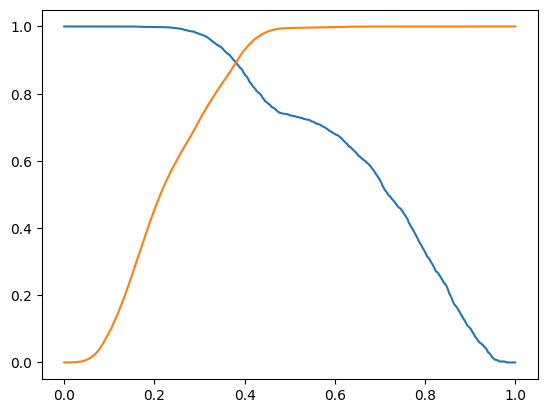

In [33]:
plt.plot(thlds, tprs)
plt.plot(thlds, tnrs)